2022 Oct 21h, Transformer refined code in progress. Need to save model config

2022 Sep 12th, testing DIY data normalization

2022 July 15th, Transformer can't use Weight_decay!

2022 July 14th, editted for Prelim model structure selection.

2022 July 1st, editted for Prelim Results plotting.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
pip install einops

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install thop

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import torch
import numpy as np
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import time
import heapq
import os
import math
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import pandas as pd
#from utils import progress_bar
from torch.autograd import Variable
import sys
from copy import deepcopy
import random
import collections
from scipy import signal
from drive.MyDrive.Wireless_Transformer.PSDshow import imshow
from drive.MyDrive.Wireless_Transformer.wrt import WrT # customized design of Wireless Transformer
from drive.MyDrive.Wireless_Transformer.wrt import WrTOct26 # new version WrT editting mean/class
from drive.MyDrive.Wireless_Transformer.AlexNet1D import AlexNet1D
# /content/drive/MyDrive/Wireless_Transformer/AlexNet1D.py
from torch.utils.data import Dataset, DataLoader
from pytz import timezone
TMZ = timezone('EST')
import datetime
import shutil
device = torch.device("cuda")
from torchsummary import summary 
from thop import profile
# torch.manual_seed(0)


Dataset description: cleanPSD64.pth, SNR-6dB, 10bands, 6PUs, 64pts/band.
3.279583692550659 2.5343174934387207
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.dropout.Dropout'>.
[INFO] Register count_normalization() for <class 'torch.nn.modules.normalization.LayerNorm'>.
[INFO] Register count_softmax() for <class 'torch.nn.modules.activation.Softmax'>.


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


macs are :
 49312.0
params are :
 6362.0
model watermark 221211_23_52
Model saved to dir:
 /content/drive/MyDrive/Wireless_Transformer/Saved_Models/WrTOct26/NoPWLKSmall/221211_23_52-6/WrTOct26_SNR-6vol100.pth
Epoch 1 :
Testing accuracy: 50.265235900878906 %; detection rate: 53.69844055175781; false alarm: 53.167964935302734
Learning rate: 0.0005
Max accuracy: 50.26523470878601 %; training loss: , 44.840114653110504
Epoch 2 :
Testing accuracy: 55.67304992675781 %; detection rate: 52.96797180175781; false alarm: 41.62187194824219
Learning rate: 0.0005
Max accuracy: 55.67305088043213 %; training loss: , 42.97561377286911
Epoch 3 :
Testing accuracy: 63.93633270263672 %; detection rate: 67.4453125; false alarm: 39.572654724121094
Learning rate: 0.0005
Max accuracy: 63.93632888793945 %; training loss: , 39.722506403923035
Epoch 4 :
Testing accuracy: 69.06133270263672 %; detection rate: 70.95625305175781; false alarm: 32.833587646484375
Learning rate: 0.0005
Max accuracy: 69.0613329410553 %; 

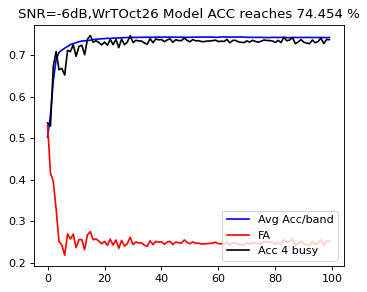

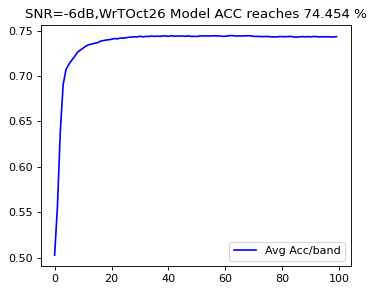

Statics saved to excel: /content/drive/MyDrive/Wireless_Transformer/Saved_Models/WrTOct26/NoPWLKSmall/221211_23_52-6/convergSNR-6.xlsx
Time spent for running100epochs 0:05:07.185739
Testing accuracy: 57.00273895263672 %; detection rate: 99.92656707763672; false alarm: 85.92109680175781
Testing accuracy: 57.29180145263672 %; detection rate: 99.92188262939453; false alarm: 85.3382797241211
Testing accuracy: 57.583988189697266 %; detection rate: 99.91328430175781; false alarm: 84.74531555175781
Testing accuracy: 57.898048400878906 %; detection rate: 99.89844512939453; false alarm: 84.10234069824219
Testing accuracy: 58.21133041381836 %; detection rate: 99.8882827758789; false alarm: 83.46562194824219
Testing accuracy: 58.52461242675781 %; detection rate: 99.87734985351562; false alarm: 82.828125
Testing accuracy: 58.80586242675781 %; detection rate: 99.87031555175781; false alarm: 82.25859069824219
Testing accuracy: 59.13945770263672 %; detection rate: 99.85781860351562; false alarm: 81.5

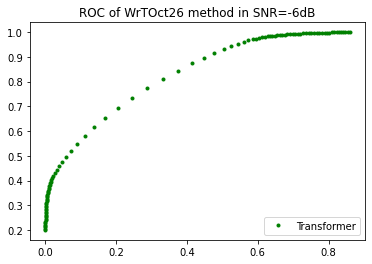

Statics saved to excel: /content/drive/MyDrive/Wireless_Transformer/Saved_Models/WrTOct26/NoPWLKSmall/221211_23_52-6/ROC_SNR-6.xlsx
ROC in Lists saved to: /content/drive/MyDrive/Wireless_Transformer/Saved_Models/WrTOct26/NoPWLKSmall/221211_23_52-6/WrTOct26ROC.pth


FileNotFoundError: ignored

In [ ]:
class ToyDatasetMaker(Dataset):
    "Toy version that wrap data/label tensor list into pytorch dataset"
    def __init__(self, data_list, label_list, transformFunc=transforms.Compose([ ]), norm_config=(1,1) ):
        """
        db: a list of input signal tensors, 
        label_list: a list of data labels, align with elements in db.
        """
        self.datasets = data_list
        self.label_list = label_list
        self.transformFunc = transformFunc
        self.norm_config = norm_config
    def __getitem__(self, i):
        img = self.datasets[i]
        img = self.transformFunc(img)
        img = (img-self.norm_config[0])/self.norm_config[1] # added for normalizing non-image
        class_label = self.label_list[i]
        return img, class_label

    def __len__(self):
        return len(self.label_list)

def adjust_learning_rate(optimizer, epoch):
    """Sets the learning rate to the initial LR decayed by 10 every 30 epochs"""
    epoch_inter = 20
#     print("Decrease learning rate every %d epoch by %2f" %(epoch_inter, des))
    #lr = 0.01 * (des ** (epoch // epoch_inter))
    bs = 1 #0.4 #0.2
    lr = 0.0005 * bs ** (epoch/epoch_inter)
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

def train(model, trainloader, epoch):
  #Transformer fail with weight_decay
  optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.002 )
  # optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=0.0 )
  adjust_learning_rate(optimizer, epoch)
  running_loss = 0.0
  model.train()
  for i, data in enumerate(trainloader, 0):
      # get the inputs; data is a list of [inputs, labels]
      inputs, labels = data
      #inputs = inputs.to(device)
      # if type(model).__name__ == 'WrT':
      inputs = Variable(inputs.view(-1, 1,1,datas_tr[0].size(0)).to(device)) #640
      # inputs = Variable(inputs.view(-1,datas_tr[0].size(0)).to(device))
      labels = Variable(labels.to(device))
      # zero the parameter gradients
      optimizer.zero_grad()
      # forward + backward + optimize
      outputs = model(inputs)
      loss = criterion(outputs, labels)
      loss.backward()
      optimizer.step()
      # print statistics
      running_loss += loss.item()
  print('Learning rate:', optimizer.param_groups[0]['lr'])
  return model, running_loss

def test(model, testloader, thresh = 0):
  total = 0 #sum of occupation and emptiness
  total_ocp = 0 #occupied bands
  total_emp = 0 #empty bands
  correct = 0
  correct_ocp = 0
  correct_emp = 0
  model.eval()
  # since we're not training, we don't need to calculate the gradients for our outputs
  with torch.no_grad():
      for data in testloader:
          inputs, labels = data
          inputs = Variable(inputs.view(-1,1,1,datas_tr[0].size(0) ).to(device)) #10bands=>640, 8bands=>512
          labels = Variable(labels.to(device)) 
          total_batch = float( torch.tensor(labels.size()).prod() ) 
          total += total_batch
          total_ocp += float(labels.sum())  #occupied bands
          total_emp += float(total_batch - labels.sum())  #empty bands
          # calculate outputs by running images through the network
          outputs = ( model(inputs)> thresh ).bool()
          labels = labels.bool()
          # the class with the highest energy is what we choose as prediction
          correct_ocp += (outputs * labels).sum() 
          correct_emp += (~outputs * ~labels).sum()
          correct = correct_ocp + correct_emp
          if (outputs * labels).sum()+(~outputs * ~labels).sum() != (~(outputs^labels)) .sum():
            print('wrong!', (outputs * labels).sum()+(~outputs * ~labels).sum(),'!=', (~(outputs^labels)).sum())

  # print(f'Accuracy of the network on the test data: {100 * correct/total} %')
  print(f'Testing accuracy: {100 * correct/total} %; detection rate: {100*correct_ocp/total_ocp}; false alarm: {100-100*correct_emp/total_emp}')
  return (correct/total, correct_ocp/total_ocp, correct_emp/total_emp) 

def setDir(filepath):
  # if directory not exist, create. if directory already exist, empty it.
  if not os.path.exists(filepath):
    os.makedirs(filepath)
  else:
    print('Directory already exists')
    shutil.rmtree(filepath, ignore_errors = True)
    os.mkdir(filepath)        

for SNR in [-6,1]: #[ -4, -8, -10, -2, 0, -1, -3,  ]: # [-1, -3]: #[-6, -4, -8, -10, -2, 0, -1, -3, 1 ]: #[-4, -6, -8, -10, -2, 0]: #[-1, -3]: #[400,200,100]:
  volum = 100 # 4000 samples per occupancy pattern
  # address1 =  '/content/drive/MyDrive/Wireless_Transformer/MesBondSW/' #WFSC/, SFWC/, AllW/
  address1 =  '/content/drive/MyDrive/Wireless_Transformer/LeftRightIndep/' #LeftRightIndep version
  # name1 = 'T_8b3P1sig_SNR'+str(SNR)+'.pth' #data of PU with the same sig
  name1 = 'T_10b5P5sig_SNR'+str(SNR)+'vol'+str(volum)+'.pth' #10bands, 5PUs, 5 kinds of sig, training & testing together
  # name1 = 'Old_Data/T_8b5P_SNR-10.pth' # 10bands failed, test on 8bands. reason found: shouldn't use weight decay for WrT 
  # name1 = 'Old_Data/T_8b3P3sig_SNR'+str(SNR)+'.pth' #8 band data with PU have the same sig
  # data_dict = torch.load(address1 + name1)
  #==================================Data_path_override======================================
  # data_dict = torch.load( '/content/drive/MyDrive/Wireless_Transformer/RefinedNewData/221024_13_53/221024_13_53Data_SNR-5vol4000.pth')
  # datadir = '/content/drive/MyDrive/Wireless_Transformer/RefinedNewData/221027_21_14/221027_21_14Data_SNR-5vol4000.pth'
  # datadir = '/content/drive/MyDrive/Wireless_Transformer/RefinedNewData/221030_17_33/221030_17_33Data_SNR-5vol4000.pth'
  datadir = '/content/drive/MyDrive/Wireless_Transformer/RefinedNewData/221030_21_21/221030_21_21Data_SNR'+str(SNR)+'vol4000.pth'
  # datadir = '/content/drive/MyDrive/Wireless_Transformer/RefinedNewData/unbonded/221116_19_42/221116_19_42Data_SNR'+str(SNR)+'vol250.pth'

  # datadir = '/content/drive/MyDrive/Wireless_Transformer/RefinedNewData/unbonded/221116_19_42/221116_19_42Data_SNR'+str(SNR)+'vol'+str(volum)+'.pth'
  data_dict = torch.load(datadir)  
  datas_te = data_dict['testing data list']
  labels_te = data_dict['testing label list']
  # datadir = '/content/drive/MyDrive/Wireless_Transformer/RefinedNewData/varyingsize/221117_21_33/221117_21_33Data_SNR-6vol'+str(volum)+'.pth'
  # datadir= '/content/drive/MyDrive/Wireless_Transformer/RefinedNewData/Smalldata100/VarySNR/221210_01_24/Data_SNR'+str(SNR)+'vol'+str(volum)+'.pth'
  # datadir = '/content/drive/MyDrive/Wireless_Transformer/RefinedNewData/SmalldataUnbond/VarySNR/221210_22_47/Data_SNR'+str(SNR)+'vol'+str(volum)+'.pth'
  datadir = '/content/drive/MyDrive/Wireless_Transformer/RefinedNewData/SmalldataNoPWLK/221210_23_08/Data_SNR'+str(SNR)+'vol'+str(volum)+'.pth'

  data_dict1 = torch.load(datadir)  
  # data_dict1 = torch.load( datadir)
  print( 'Dataset description:', data_dict1['Description'] )
  datas_tr = data_dict1['training data list']
  labels_tr = data_dict1['training label list']

  num_bands = labels_te[0] 

  #calculating mean and std
  datas_all = datas_tr+datas_te
  data_tens =torch.cat(datas_all,dim=0)
  (data_mean, data_std) = ( torch.mean(data_tens).item(), torch.std(data_tens).item() )
  print(data_mean, data_std)

  trainset= ToyDatasetMaker(datas_tr, labels_tr, norm_config=(data_mean, data_std) )
  testset= ToyDatasetMaker(datas_te, labels_te, norm_config=(data_mean, data_std) )
  train_loader = DataLoader(trainset, batch_size=min(500, volum), shuffle=True, num_workers=12, pin_memory=True)
  test_loader = DataLoader(testset, batch_size=1000, shuffle=False, num_workers=12, pin_memory=True)

  # WrT_var={
  #     'spectra_size': (1, datas_tr[0].size(0)),
  #     'patch_size': (1,320),
  #     'num_bands': labels_te[0].size(0),
  #     'dim': 64,
  #     'depth': 3,
  #     'heads': 4,
  #     'mlp_dim': 128,
  #     'dropout': .1,
  #     'dim_head': 16,
  #     'emb_dropout': .1,
  #     'pool': 'mean',
  #     'Description': 'None',
  #     'Data_dir': datadir,
  # }


  WrT_var={ #
  'spectra_size': (1,datas_tr[0].size(0)),'patch_size':(1,64),'num_bands':labels_te[0].size(0),'dim':8,
  'depth':1,'heads':8,'mlp_dim':16,'dropout':.1,'dim_head':8,'emb_dropout':.1,'pool':'mean','Description':'None', 'Data_dir': datadir,} 
  #;

  WrT_var={ #
  'spectra_size': (1,datas_tr[0].size(0)),'patch_size':(1,64),'num_bands':labels_te[0].size(0),'dim':2,
  'depth':1,'heads':1,'mlp_dim':2,'dropout':.1,'dim_head':2,'emb_dropout':.1,'pool':'mean','Description':'None', 'Data_dir': datadir,} 
  #;

  WrT_var={ #
  'spectra_size': (1,datas_tr[0].size(0)),'patch_size':(1,64),'num_bands':labels_te[0].size(0),'dim':16,
  'depth':1,'heads':4,'mlp_dim':32,'dropout':.1,'dim_head':8,'emb_dropout':.1,'pool':'mean','Description':'None', 'Data_dir': datadir,} 
  #;

  # WrT_var={ #1114
  # 'spectra_size': (1,datas_tr[0].size(0)),'patch_size':(1,64),'num_bands':labels_te[0].size(0),'dim':4,
  # 'depth':1,'heads':4,'mlp_dim':4,'dropout':.1,'dim_head':4,'emb_dropout':.1,'pool':'mean','Description':'None', 'Data_dir': datadir,} 
  # #;

  # from IPython.core.interactiveshell import ensure_dir_exists
  v = WrTOct26(
      spectra_size = WrT_var['spectra_size'],
      patch_size = WrT_var['patch_size'],
      num_bands = WrT_var['num_bands'],
      dim = WrT_var['dim'], # 512
      depth = WrT_var['depth'], #6
      heads = WrT_var['heads'], #8
      mlp_dim = WrT_var['mlp_dim'], #1024
      dropout = WrT_var['dropout'],
      dim_head = WrT_var['dim_head'],
      emb_dropout = WrT_var['emb_dropout'],
      pool = WrT_var['pool'],
  )

  # for i, data in enumerate(train_loader, 0):
  #   if i>0:
  #     break
  #   inputs, labels = data
  #   inputs = Variable(inputs.view(-1, 1,1,datas_tr[0].size(0)).to(device))
  #   v(inputs)

  criterion = nn.BCEWithLogitsLoss()
  # summary(v, (1,1,640))

  macs, params = profile(v, inputs =(torch.randn(1, 1, 1, 640), )) #model on CPU
  print('macs are :\n',macs)
  print('params are :\n',params)
  v = v.to(device)

  nepoch = 100
  acc_list = []
  acc_ocp_list = []
  fa_list = []
  # plt.title("Global Model ACC of the proposed method")
  max_acc = 0
  now=datetime.datetime.now(TMZ) #time watermark
  time_watermark = now.strftime('%y%m%d_%H_%M')
  print('model watermark',time_watermark)
  # address_model = '/content/drive/MyDrive/Wireless_Transformer/Saved_Models/'+type(v).__name__+'/unbond/'+time_watermark+'/' #root dir for saved models
  # address_model = '/content/drive/MyDrive/Wireless_Transformer/Saved_Models/'+type(v).__name__+'/'+time_watermark+str(SNR)+'/' #root dir for saved models
  # address_model = '/content/drive/MyDrive/Wireless_Transformer/Saved_Models/'+type(v).__name__+'/unbondSmall/'+time_watermark+str(SNR)+'/' #root dir for saved models
  address_model = '/content/drive/MyDrive/Wireless_Transformer/Saved_Models/'+type(v).__name__+'/NoPWLKSmall/'+time_watermark+str(SNR)+'/' #root dir for saved models


  #child dir nbamed by time_watermark
  setDir(address_model) # if dir not exist, create. if dir already exist, empty it.
  name1 = type(v).__name__ +'_SNR'+str(SNR)+'vol'+str(volum)+'.pth'
  print('Model saved to dir:\n', address_model+name1)
  torch.save(WrT_var, address_model+type(v).__name__+'config.pth') #Save WrT model config
  txt=open(address_model+'Datasetdir.txt',"w").write(datadir+' very small model To find Gap')#save dataset dir (dataset version)
  
  for i in range(nepoch):
    print('Epoch', i+1,':')      
    acc_ = test(v, test_loader)
    
    if acc_[0].cpu().item() > max_acc:
      max_acc = acc_[0].cpu().item()
      torch.save(v.state_dict(), address_model+name1)

    acc_list.append( acc_[0].cpu().item())
    acc_ocp_list.append(acc_[1].cpu().item())
    fa_list.append((1-acc_[2]).cpu().item())  

    #uniform the y axis, label SNR on title
    v, training_loss = train(v, train_loader, epoch=i)# Test first and train then version
    print(f'Max accuracy: {100 * max_acc} %; training loss: , {training_loss}')

  plt.figure(1,figsize=(5, 4), dpi=80) 
  l1, = plt.plot( acc_list, color='blue',label='Avg Acc/band')
  l2, = plt.plot( fa_list, color='red', label='FA')
  l3, = plt.plot( acc_ocp_list, color='black', label='Acc 4 busy')
  plt.legend(loc='lower right')
  plt.title('SNR='+str(SNR)+'dB,'+ type(v).__name__+ ' Model ACC reaches %.3f %%' %  (100*max(acc_list))  )
  plt.show()

  plt.figure(2,figsize=(5, 4), dpi=80)
  l1, = plt.plot( acc_list, color='blue',label='Avg Acc/band')
  # l2, = plt.plot( fa_list, color='red', label='FA')
  # l3, = plt.plot( acc_ocp_list, color='black', label='Acc 4 busy')
  plt.legend(loc='lower right')
  plt.title('SNR='+str(SNR)+'dB,'+ type(v).__name__+ ' Model ACC reaches %.3f %%' %  (100*max(acc_list))  )
  plt.show()

  df1 = pd.DataFrame() # save statics to excel
  # df1['acc_old'] = xx
  df1['Accuracy'] = acc_list
  df1['FA'] = fa_list
  df1['PD'] = acc_ocp_list 

  with pd.ExcelWriter(address_model + "converg"+"SNR"+str(SNR)+".xlsx", mode='w') as writer:  #mode was 'a'
    df1.to_excel(writer, sheet_name=type(v).__name__)
  print('Statics saved to excel:', address_model + "converg"+"SNR"+str(SNR)+".xlsx")

  finish_tim=datetime.datetime.now(TMZ)
  print('Time spent for running'+str(nepoch)+'epochs',finish_tim - now)

  '''ROC module of current model'''
  pd3= []
  pfa3 = []
  v.load_state_dict(torch.load(address_model+name1))

  for thresh_val in [ (i-50)/12.5 for i in range(100)]: 
    #[i*0.9999/100 for i in list(range(1,100))]
    # in [(1-i/50)*5e-8+1e-10 for i in list(range(50))]
      CNNoutput = test(v, test_loader, thresh=thresh_val) #
      #testnets( net_list, class_dir, tol_test_loader, thresh_sig = thresh_val )
      pd3.append(CNNoutput[1].to(torch.device('cpu')).item())
      pfa3.append(1-CNNoutput[2].to(torch.device('cpu')).item())

  plt.title("ROC of " +type(v).__name__+ " method in SNR="+str(SNR)+"dB")
  l3, = plt.plot(pfa3, pd3, '.', color='green', label='Transformer')
  plt.legend(loc='lower right')
  plt.show()

  dfroc = pd.DataFrame() # save statics to excel
  # df1['acc_old'] = xx
  dfroc['PD'] = pd3
  dfroc['PFA'] = pfa3


  with pd.ExcelWriter(address_model + "ROC_SNR"+str(SNR)+".xlsx", mode='w') as writer:  #mode was 'a'
    dfroc.to_excel(writer, sheet_name=type(v).__name__)
  print('Statics saved to excel:', address_model + "ROC_SNR"+str(SNR)+".xlsx")

  ROC_dict = {
      'pd':pd3,
      'pfa':pfa3,
  }
  torch.save(ROC_dict, address_model+type(v).__name__+'ROC.pth')
  print('ROC in Lists saved to:', address_model+type(v).__name__+'ROC.pth')



In [ ]:
# #If training stop half way, use this cell to plot converg and calculate ROC
# plt.figure(1,figsize=(5, 4), dpi=80) 
# l1, = plt.plot( acc_list, color='blue',label='Avg Acc/band')
# l2, = plt.plot( fa_list, color='red', label='FA')
# l3, = plt.plot( acc_ocp_list, color='black', label='Acc 4 busy')
# plt.legend(loc='lower right')
# plt.title('SNR='+str(SNR)+'dB,'+ type(v).__name__+ ' Model ACC reaches %.3f %%' %  (100*max(acc_list))  )
# plt.show()

# plt.figure(2,figsize=(5, 4), dpi=80)
# l1, = plt.plot( acc_list, color='blue',label='Avg Acc/band')
# # l2, = plt.plot( fa_list, color='red', label='FA')
# # l3, = plt.plot( acc_ocp_list, color='black', label='Acc 4 busy')
# plt.legend(loc='lower right')
# plt.title('SNR='+str(SNR)+'dB,'+ type(v).__name__+ ' Model ACC reaches %.3f %%' %  (100*max(acc_list))  )
# plt.show()

# df1 = pd.DataFrame() # save statics to excel
# # df1['acc_old'] = xx
# df1['Accuracy'] = acc_list
# df1['FA'] = fa_list
# df1['PD'] = acc_ocp_list 

# with pd.ExcelWriter(address_model + "converg"+"SNR"+str(SNR)+".xlsx", mode='w') as writer:  #mode was 'a'
#   df1.to_excel(writer, sheet_name=type(v).__name__)
# print('Statics saved to excel:', address_model + "converg"+"SNR"+str(SNR)+".xlsx")

# finish_tim=datetime.datetime.now(TMZ)
# print('Time spent for running'+str(nepoch)+'epochs',finish_tim - now)

# '''ROC module of current model'''
# pd3= []
# pfa3 = []
# v.load_state_dict(torch.load(address_model+name1))

# for thresh_val in [ (i-50)/12.5 for i in range(100)]: 
#   #[i*0.9999/100 for i in list(range(1,100))]
#   # in [(1-i/50)*5e-8+1e-10 for i in list(range(50))]
#     CNNoutput = test(v, test_loader, thresh=thresh_val) #
#     #testnets( net_list, class_dir, tol_test_loader, thresh_sig = thresh_val )
#     pd3.append(CNNoutput[1].to(torch.device('cpu')).item())
#     pfa3.append(1-CNNoutput[2].to(torch.device('cpu')).item())

# plt.title("ROC of " +type(v).__name__+ " method in SNR="+str(SNR)+"dB")
# l3, = plt.plot(pfa3, pd3, '.', color='green', label='Transformer')
# plt.legend(loc='lower right')
# plt.show()

# dfroc = pd.DataFrame() # save statics to excel
# # df1['acc_old'] = xx
# dfroc['PD'] = pd3
# dfroc['PFA'] = pfa3


# with pd.ExcelWriter(address_model + "ROC_SNR"+str(SNR)+".xlsx", mode='w') as writer:  #mode was 'a'
#   dfroc.to_excel(writer, sheet_name=type(v).__name__)
# print('Statics saved to excel:', address_model + "ROC_SNR"+str(SNR)+".xlsx")

# ROC_dict = {
#     'pd':pd3,
#     'pfa':pfa3,
# }
# torch.save(ROC_dict, address_model+type(v).__name__+'ROC.pth')
# print('ROC in Lists saved to:', address_model+type(v).__name__+'ROC.pth')

In [ ]:
from google.colab import runtime
runtime.unassign()

In [ ]:

# v = WrT(
#     spectra_size = WrT_var['spectra_size'],
#     patch_size = WrT_var['patch_size'],
#     num_bands = WrT_var['num_bands'],
#     dim = WrT_var['dim'], # 512
#     depth = WrT_var['depth'], #6
#     heads = WrT_var['heads'], #8
#     mlp_dim = WrT_var['mlp_dim'], #1024
#     dropout = WrT_var['dropout'],
#     dim_head = WrT_var['dim_head'],
#     emb_dropout = WrT_var['emb_dropout'],
#     pool = WrT_var['pool'],
# ).to(device)

# #not good with depth: 3 heads 4 dim 64 mlpdim 128
# criterion = nn.BCEWithLogitsLoss()

# # v = AlexNet1D(num_classes = 10).to(device)
# summary(v, (1,1,640))

In [ ]:
# #long word 320
# v = WrT(
#     spectra_size = (1, datas_tr[0].size(0)),
#     patch_size = (1,320),
#     num_bands = labels_te[0].size(0),
#     dim = 64, # 512
#     depth = 3, #6
#     heads = 4, #8
#     mlp_dim = 128, #1024
#     dropout = 0.1,
#     dim_head = 16,
#     emb_dropout = 0.1,
#     pool = 'mean'
# ).to(device)

# #not good with depth: 3 heads 4 dim 64 mlpdim 128
# criterion = nn.BCEWithLogitsLoss()

In [ ]:
# #short word 64
# v = WrT(
#     spectra_size = (1, datas_tr[0].size(0)),
#     patch_size = (1,64),
#     num_bands = labels_te[0].size(0),
#     dim = 8, # 512
#     depth = 1, #6
#     heads = 1, #8
#     mlp_dim = 16, #1024
#     dropout = 0.1,
#     dim_head = 8,
#     emb_dropout = 0.1,
#     pool = 'mean'
# ).to(device)

# #not good with depth: 3 heads 4 dim 64 mlpdim 128
# criterion = nn.BCEWithLogitsLoss()

In [ ]:
# finish_tim=datetime.datetime.now(TMZ)
# print('Time spent for running'+str(nepoch)+'epochs',finish_tim - now)

In [ ]:
# plt.title("ROC of " +type(v).__name__+ " method in SNR="+str(SNR)+"dB")
# l3, = plt.plot(pfa3, pd3, color='green', label='Transformer')
# plt.legend(loc='lower right')
# plt.show()

In [ ]:

# ROC_dict=torch.load('')  #load another result for reference
# plt.title("ROC of several methods at SNR="+str(SNR)+'dB')
# # l1, = plt.plot(pfa, pd, color='blue',label='EnergyDetection1')
# l2, = plt.plot(ROC_dict['pfa'], ROC_dict['pd'], color='red', label='Transformer')
# l3, = plt.plot(pfa3, pd3, color='green', label='Transformer')
# plt.legend(loc='lower right')
# plt.show()
